In [ ]:
# Get data from here: https://datahack.analyticsvidhya.com/contest/practice-problem-identify-the-digits/

In [40]:
## Very simple sample process of using Tensorflow

# import tensorflow
import tensorflow as tf

# build computational graph
a = tf.placeholder(tf.int16)
b = tf.placeholder(tf.int16)

addition = tf.add(a, b)

# initialize variables
init = tf.global_variables_initializer()

# create session and run the graph
with tf.Session() as sess:
    sess.run(init)
    print "Addition: %i" % sess.run(addition, feed_dict={a: 7, b: 9})

# close session
sess.close()

Addition: 16


In [ ]:
# Basic Steps to build NN

'''
Define Neural Network architecture
Transfer data to your model
Divide Data into batches. The batches are first preprocessed, augmented and then fed into Neural Network for training
The model then gets trained incrementally
Display the accuracy for a specific number of timesteps
After training save the model for future use
Test the model on a new data and check how it performs
'''

# Below is digit recignition
## Using eed forward multilayer perceptron here, but you have freedom to choose which architecture to build

In [4]:
%pylab inline

import os
import numpy as np
import pandas as pd
from scipy.misc import imread
from sklearn.metrics import accuracy_score
import tensorflow as tf

Populating the interactive namespace from numpy and matplotlib


In [41]:
seed = 410
rng = np.random.RandomState(seed)

train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

train.head()

,filename,label
0,0.png,4
1,1.png,9
2,2.png,1
3,3.png,7
4,4.png,3


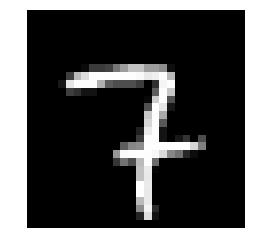

In [49]:
img_name = rng.choice(train.filename)
filepath = os.path.join('data/Images/train/', img_name)

img = imread(filepath, flatten=True)

pylab.imshow(img, cmap='gray')
pylab.axis('off')
pylab.show()

In [50]:
# store all our images as numpy arrays, for easier data manipulation

temp = []
for img_name in train.filename:
    image_path = os.path.join('data/Images/train/', img_name)
    img = imread(image_path, flatten=True)
    img = img.astype('float32')
    temp.append(img)
    
train_x = np.stack(temp)

temp = []
for img_name in test.filename:
    image_path = os.path.join('data/Images/test/', img_name)
    img = imread(image_path, flatten=True)
    img = img.astype('float32')
    temp.append(img)
    
test_x = np.stack(temp)

In [51]:
# Split training and validation data into 7:3

split_size = int(train_x.shape[0]*0.7)

train_x, val_x = train_x[:split_size], train_x[split_size:]
train_y, val_y = train.label.values[:split_size], train.label.values[split_size:]

In [52]:
# Different from Keras, you need to define these functions on your own

def dense_to_one_hot(labels_dense, num_classes=10):    # 0 to 9, 10 classes
    """Convert class labels from scalars to one-hot vectors"""
    num_labels = labels_dense.shape[0]
    index_offset = np.arange(num_labels) * num_classes
    labels_one_hot = np.zeros((num_labels, num_classes))
    labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1
    
    return labels_one_hot


def preproc(unclean_batch_x):
    """Convert values to range 0-1"""
    temp_batch = unclean_batch_x / unclean_batch_x.max()
    
    return temp_batch


def batch_creator(batch_size, dataset_length, dataset_name):
    """Create batch with random samples and return appropriate format"""
    batch_mask = rng.choice(dataset_length, batch_size)
    
    batch_x = eval(dataset_name + '_x')[[batch_mask]].reshape(-1, input_num_units)
    batch_x = preproc(batch_x)
    
    if dataset_name == 'train':
        batch_y = eval(dataset_name).ix[batch_mask, 'label'].values
        batch_y = dense_to_one_hot(batch_y)
        
    return batch_x, batch_y

In [55]:
# Set Variables

input_num_units = 28*28    # size of original images
hidden_num_units = 410    # number of neurnos in each layer
output_num_units = 10

# define placeholders
x = tf.placeholder(tf.float32, [None, input_num_units])
y = tf.placeholder(tf.float32, [None, output_num_units])

# set remaining variables
epochs = 7
batch_size = 179
learning_rate = 0.01


weights = {
    'hidden': tf.Variable(tf.random_normal([input_num_units, hidden_num_units], seed=seed)),
    'output': tf.Variable(tf.random_normal([hidden_num_units, output_num_units], seed=seed))
}

biases = {
    'hidden': tf.Variable(tf.random_normal([hidden_num_units], seed=seed)),
    'output': tf.Variable(tf.random_normal([output_num_units], seed=seed))
}

In [57]:
# Build neural networks computational graph

hidden_layer = tf.add(tf.matmul(x, weights['hidden']), biases['hidden'])
hidden_layer = tf.nn.relu(hidden_layer)

output_layer = tf.matmul(hidden_layer, weights['output']) + biases['output']

## cost of the graph
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits = output_layer))

## Using Adam optimizer here
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

In [59]:
init = tf.global_variables_initializer()

with tf.Session() as sess:
    # initialize variables
    sess.run(init)
    
    ### for each epoch, do:
    ###   for each batch, do:
    ###     create pre-processed batch
    ###     run optimizer by feeding batch
    ###     find cost and reiterate to minimize
    
    for epoch in range(epochs):
        avg_cost = 0
        total_batch = int(train.shape[0]/batch_size)
        for i in range(total_batch):
            batch_x, batch_y = batch_creator(batch_size, train_x.shape[0], 'train')
            _, c = sess.run([optimizer, cost], feed_dict = {x: batch_x, y: batch_y})
            
            avg_cost += c / total_batch
            
        print "Epoch:", (epoch+1), "cost =", "{:.5f}".format(avg_cost)
    
    print "\nTraining complete!"
    
    pred_temp = tf.equal(tf.argmax(output_layer, 1), tf.argmax(y, 1))
    accuracy = tf.reduce_mean(tf.cast(pred_temp, "float"))
    print "Validation Accuracy:", accuracy.eval({x: val_x.reshape(-1, input_num_units), y: dense_to_one_hot(val_y)})
    
    predict = tf.argmax(output_layer, 1)
    pred = predict.eval({x: test_x.reshape(-1, input_num_units)})

Epoch: 1 cost = 8.93436
Epoch: 2 cost = 1.65344
Epoch: 3 cost = 0.84183
Epoch: 4 cost = 0.49784
Epoch: 5 cost = 0.36253
Epoch: 6 cost = 0.24408
Epoch: 7 cost = 0.21394

Training complete!
Validation Accuracy: 0.955782


Prediction is:  9


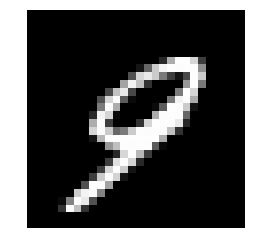

In [63]:
img_name = rng.choice(test.filename)
filepath = os.path.join('data/Images/test/', img_name)

img = imread(filepath, flatten=True)

test_index = int(img_name.split('.')[0]) - 49000

print "Prediction is: ", pred[test_index]

pylab.imshow(img, cmap='gray')
pylab.axis('off')
pylab.show()